# Skin Binary Classification

## Libraries

In [ ]:
from Dataset.Data_Loaders import get_loader
from Conventional.Preprocessing import transforms
from Conventional.Feature_extraction import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

from PIL import Image
import pywt

from monai.data import pad_list_data_collate
from skimage.filters import gabor, gabor_kernel
from skimage.util import img_as_ubyte
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage import data, filters, color
from skimage.transform import radon, rescale
from scipy.stats import kurtosis, skew
from skimage.measure import regionprops, label
from scipy.spatial.distance import directed_hausdorff


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

## Feature extraction

In [ ]:
# Data_path=r"C:\Users\moham\My Files\Education\UDG\CAD\skin_binary_dataset"
Data_path = r"E:/7th year/Girona courses/CAD/Project/Dataset"

train_loader= get_loader(Data_path,mode="train",shuffle=True,transforms=transforms)
val_loader= get_loader(Data_path,mode="val",shuffle=True,transforms=transforms)
test_loader= get_loader(Data_path,mode="test",shuffle=False,transforms=transforms)

features=[]
Labels=[]

features_val=[]
Labels_val=[]

test_features=[]

In [ ]:
for j, batch in enumerate(train_loader):
    for i in range(len(batch['label'])):
        # seg_image = batch['segmented_image'][i].numpy().transpose(0, 1, 2)
        image=batch['image'][i].numpy().transpose(1, 2, 0)
        # bin_image =  np.squeeze(batch['image_otsu'][i].numpy().transpose(1,2,0))
        color_feature=color_features(image)
        gray_level_features= calculate_glcm(image)
        # Haralick_feats=haralick_features(image)
        # HOG_feats=calculate_hog(image)
        pattern=calculate_lbp(image)
        entropy_feats=Entropy(image)
        kurtosis_feats=calculate_kurtosis(image)
        contrast_feats=contrast_entropy(image)
        Gabor_feats=calculate_gabor(image)
        #segmentation_feature = segmentation_features(bin_image)
        # more = more_features(seg_image)
        combined_features = np.concatenate([np.array(entropy_feats),np.array(kurtosis_feats),np.array(color_feature),
                                        np.array(Gabor_feats),np.array(gray_level_features),np.array(pattern),
                                        np.array(contrast_feats)]) 
        features.append(combined_features)
        Labels.append(f"{batch['label'][i].item()}")

In [ ]:
for j, batch in enumerate(val_loader):
    for i in range(len(batch['label'])):
        # seg_image = batch['segmented_image'][i].numpy().transpose(0, 1, 2)
        image=batch['image'][i].numpy().transpose(1, 2, 0)  
        # bin_image =  np.squeeze(batch['image_otsu'][i].numpy().transpose(1,2,0))
        color_feature=color_features(image)
        gray_level_features= calculate_glcm(image)
        # HOG_feats=calculate_hog(image)
        pattern=calculate_lbp(image)
        entropy_feats=Entropy(image)
        # Haralick_feats=haralick_features(image)
        kurtosis_feats=calculate_kurtosis(image)
        contrast_feats=contrast_entropy(image)
        Gabor_feats=calculate_gabor(image)
        # segmentation_feature = segmentation_features(bin_image)
        # more = more_features(seg_image)
        combined_features = np.concatenate([np.array(entropy_feats),np.array(kurtosis_feats),np.array(color_feature),
                                        np.array(Gabor_feats),np.array(gray_level_features),np.array(pattern),
                                        np.array(contrast_feats)])  
        features_val.append(combined_features)
        Labels_val.append(f"{batch['label'][i].item()}")

In [ ]:
for j, batch in enumerate(test_loader):
    for i in range(len(batch['image'])):
        # seg_image = batch['segmented_image'][i].numpy().transpose(0, 1, 2)
        image=batch['image'][i].numpy().transpose(1, 2, 0)
        # bin_image =  np.squeeze(batch['image_otsu'][i].numpy().transpose(1,2,0))
        color_feature=color_features(image)
        gray_level_features= calculate_glcm(image)
        # Haralick_feats=haralick_features(image)
        # HOG_feats=calculate_hog(image)
        pattern=calculate_lbp(image)
        entropy_feats=Entropy(image)
        kurtosis_feats=calculate_kurtosis(image)
        contrast_feats=contrast_entropy(image)
        Gabor_feats=calculate_gabor(image)
        #segmentation_feature = segmentation_features(bin_image)
        # more = more_features(seg_image)
        combined_features = np.concatenate([np.array(entropy_feats),np.array(kurtosis_feats),np.array(color_feature),
                                        np.array(Gabor_feats),np.array(gray_level_features),np.array(pattern),
                                        np.array(contrast_feats)]) 
        test_features.append(combined_features)

## ML models

### Clean Feature maps

In [10]:
def clean_feature_map(feature_map):
    feature_map = np.nan_to_num(feature_map, nan=0.0, posinf=100000.0, neginf=-100000.0)
    return feature_map

features = clean_feature_map(features)
features_val = clean_feature_map(features_val)

### Main model trained on train and validated on val

In [ ]:
X_train = features
X_test = features_val
Y_train = Labels
Y_test = Labels_val

# Substitute NaNs with zeros in X_train and X_test
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


# Proceed with the rest of your pipeline
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

pca = PCA(n_components=35)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define the parameter grid for SVM
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }

best_params = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'auto'
}

# Initialize the SVM model and grid search
svm = SVC(**best_params)
# grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
model = svm.fit(X_train_pca, Y_train)
y_pred = model.predict(X_test_pca)
# # Fit grid search
# grid_search.fit(X_train_pca, Y_train_resampled)

# # Get the best model and make predictions
# best_svm = grid_search.best_estimator_
# y_pred = best_svm.predict(X_test_pca)

accuracy = accuracy_score(Y_test, y_pred)
print(f"SVM accuracy: {accuracy:.4f}")
# print(f"Best parameters: {grid_search.best_params_}")

# Train and evaluate the RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train_pca, Y_train)
y_pred = model.predict(X_test_pca)

accuracy = accuracy_score(Y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {accuracy:.4f}")

SVM accuracy: 0.8174
Random Forest Classifier Accuracy: 0.8116


### CV on both train and val

In [ ]:
X_train = features
X_test = features_val
Y_train = Labels
Y_test = Labels_val

# Combine training and validation features
X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((Y_train, Y_test), axis=0)

# Substitute NaNs with zeros in X
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_imputed = imputer.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA
pca = PCA(n_components=35)
X_pca = pca.fit_transform(X_scaled)

# Set up 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# SVM model with cross-validation
svm = SVC(C=10, kernel='rbf', gamma='auto')
svm_accuracies = cross_val_score(svm, X_pca, Y, cv=cv, scoring='accuracy')
print(f"SVM cross-validated accuracy: {svm_accuracies.mean():.4f} ± {svm_accuracies.std():.4f}")

# Random Forest model with cross-validation
rf = RandomForestClassifier()
rf_accuracies = cross_val_score(rf, X_pca, Y, cv=cv, scoring='accuracy')
print(f"Random Forest cross-validated accuracy: {rf_accuracies.mean():.4f} ± {rf_accuracies.std():.4f}")

## Testing

In [ ]:
# Rename variables as specified
X_train1 = features         # Training features from the main dataset
X_train2 = features_val     # Validation features
Y_train1 = Labels           # Training labels
Y_train2 = Labels_val       # Validation labels
X_test = test_features      # Test features for final prediction

# Combine train and validation data for training
X_train_combined = np.concatenate((X_train1, X_train2), axis=0)
Y_train_combined = np.concatenate((Y_train1, Y_train2), axis=0)

# Substitute NaNs with zeros in combined train+val data and test data
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_combined_imputed = imputer.fit_transform(X_train_combined)
X_test_imputed = imputer.transform(X_test)  # Impute test data

# Standardize features
scaler = StandardScaler()
X_train_combined_scaled = scaler.fit_transform(X_train_combined_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Apply PCA
pca = PCA(n_components=35)
X_train_combined_pca = pca.fit_transform(X_train_combined_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Set up 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# SVM model with cross-validation
svm = SVC(C=10, kernel='rbf', gamma='auto')
svm_accuracies = cross_val_score(svm, X_train_combined_pca, Y_train_combined, cv=cv, scoring='accuracy')
print(f"SVM cross-validated accuracy: {svm_accuracies.mean():.4f} ± {svm_accuracies.std():.4f}")

# Train the final SVM model on full train+val data and evaluate on test data
svm.fit(X_train_combined_pca, Y_train_combined)
predictions_svm = svm.predict(X_test_pca)
print("SVM predicted labels shape:", predictions_svm.shape)

svm_output_path = "E:/7th year/Girona courses/CAD/Project/predictions/svm_predictions.csv"

pd.DataFrame(predictions_svm).to_csv(svm_output_path, index=False, header=False)

rf = RandomForestClassifier()
rf_accuracies = cross_val_score(rf, X_train_combined_pca, Y_train_combined, cv=cv, scoring='accuracy')
print(f"Random Forest cross-validated accuracy: {rf_accuracies.mean():.4f} ± {rf_accuracies.std():.4f}")

rf.fit(X_train_combined_pca, Y_train_combined)
predictions_rf = rf.predict(X_test_pca)
print("Random Forest predicted labels shape:", predictions_rf.shape)

rf_output_path = "E:/7th year/Girona courses/CAD/Project/predictions/rf_predictions.csv"
pd.DataFrame(predictions_rf).to_csv(rf_output_path, index=False, header=False)


SVM cross-validated accuracy: 0.8207 ± 0.0061
SVM predicted labels shape: (6340,)
Random Forest cross-validated accuracy: 0.8111 ± 0.0081
Random Forest predicted labels shape: (6340,)


## Border visualization

batch 0


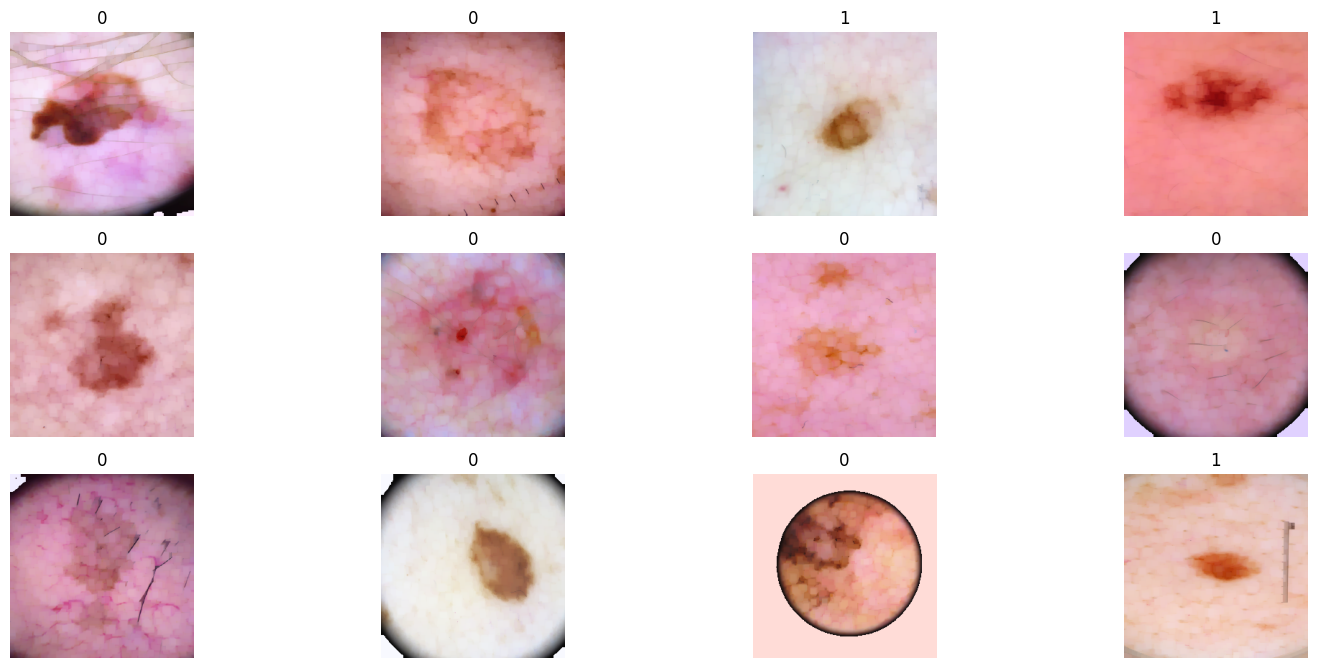

batch 1


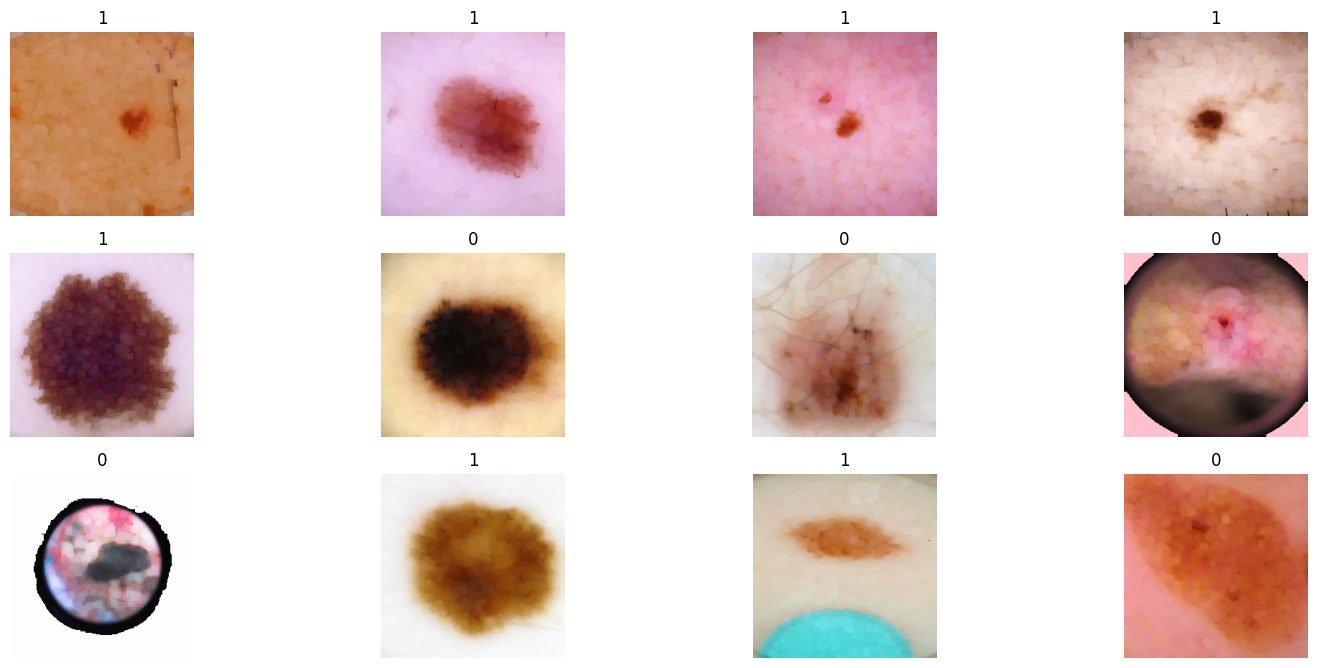

batch 2


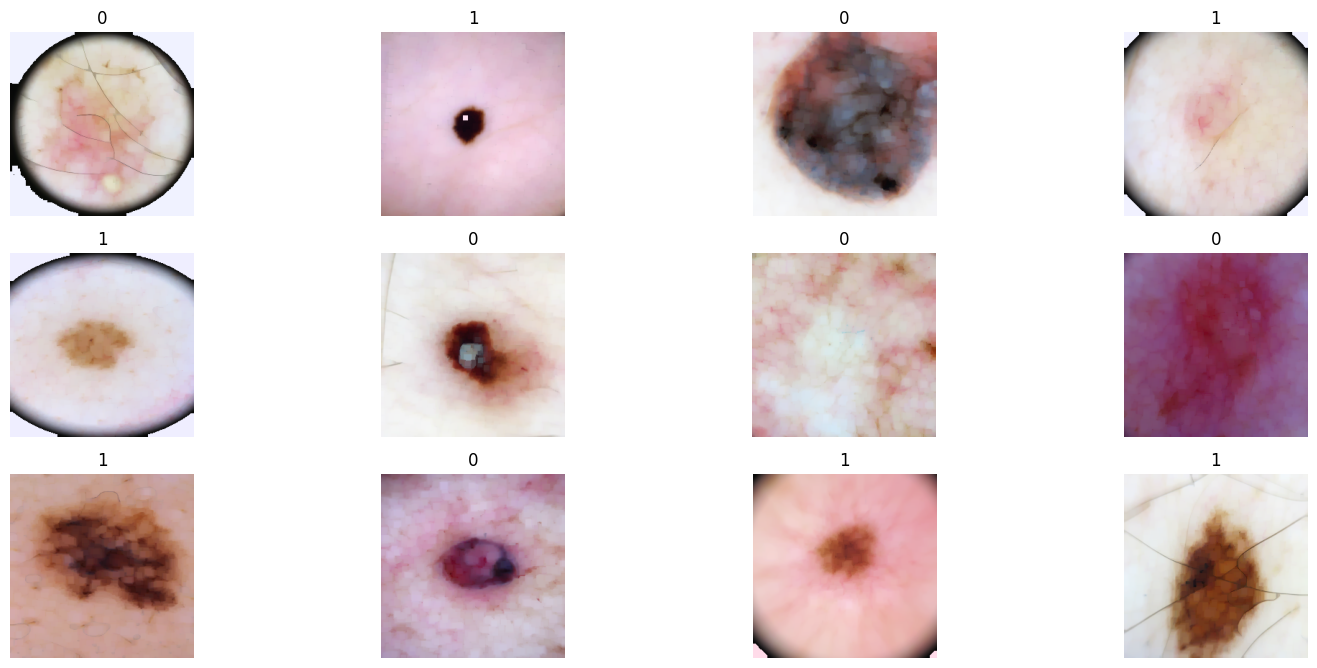

In [1]:
from Dataset.Data_Loaders import get_loader
import matplotlib.pyplot as plt
from Conventional.Preprocessing import transforms
import numpy as np


Data_path=r"C:\Users\moham\My Files\Education\UDG\CAD\skin_binary_dataset"
train_loader= get_loader(Data_path,mode="train",shuffle=True,transforms=transforms)
val_loader= get_loader(Data_path,mode="val",shuffle=True,transforms=transforms)

for j, batch in enumerate(train_loader):
    print(f"batch {j}")
    plt.figure(figsize=(15,9))
    for i in range(len(batch['label'])):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.imshow( batch['edgeremoved'][i].numpy().transpose(1, 2, 0))  # Convert to numpy for plt
        plt.title(f"{batch['label'][i].item()}")
    plt.tight_layout()
    plt.show()
    if j==2:
        break